In [1]:
import sys
sys.path.append("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import matplotlib.animation as animation
import scipy as sc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Fonctions utiles

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
n_runs = len(meta)
n_wins = 464
dfc_train_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_test_propofol = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))
dfc_train_background = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
dfc_test_background = dfc[(meta["monkey"] == "jade")].reshape((-1, n_wins, 82, 82))
conditions_train = meta["condition"][meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
conditions_test = meta["condition"][meta["monkey"].isin(['jade']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
dict_conditions = {"light-propofol":0, "deep-propofol":1}
labels_train = [dict_conditions[elem] for elem in conditions_train]
labels_test = [dict_conditions[elem] for elem in conditions_test]

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
iu = np.triu_indices(82,k=1)
dfc_flat = dfc[:,:,iu[0],iu[1]]

id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol"]
id_sessions_deep_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]

In [14]:
id_sessions_almira = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "almira" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_jade = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_khali = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "khali" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_kimiko = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "kimiko" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_rana = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "rana" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]

## PCA on awake-sevoflurane dataset

In [17]:
id_sessions_sevoflurane = np.concatenate([id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_sevoflurane_subjects = np.concatenate([id_sessions_jade,id_sessions_kimiko,id_sessions_rana])
id_sessions_awake_sevoflurane = np.concatenate([id_sessions_awake,id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane]).astype(int)
id_sessions_awake_propofol = np.concatenate([id_sessions_awake,id_sessions_light_propofol,id_sessions_deep_propofol]).astype(int)
X = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
y = np.array(["awake"]*461*len(id_sessions_awake) + ["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane))
y_num = np.array([-1]*461*len(id_sessions_awake) + [0]*461*len(id_sessions_light_sevoflurane) + [1]*461*len(id_sessions_deep_sevoflurane))
X_propofol = dfc_flat[id_sessions_awake_propofol,:,:].reshape(-1,3321)
X_sevoflurane = dfc_flat[id_sessions_sevoflurane,:,:].reshape(-1,3321)
y_sevoflurane = np.array(["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane))
y_sevoflurane_num = np.array([-1]*461*len(id_sessions_light_sevoflurane) + [1]*461*len(id_sessions_deep_sevoflurane))
X_all_subjects = dfc_flat[id_sessions_sevoflurane_subjects,:,:].reshape(-1,3321)
y_all_subjects = np.array(["jade"]*461*len(id_sessions_jade) + ["kimiko"]*461*len(id_sessions_kimiko) + ["rana"]*461*len(id_sessions_rana))

In [18]:
pca = PCA(n_components=300)
X_sevoflurane_reduced = pca.fit_transform(X_sevoflurane)
mean = np.mean(X_sevoflurane,axis = 0)

v = pca.components_.T
X_sevoflurane_reduced = (X_sevoflurane - mean).dot(v)
X_propofol_reduced = (X_propofol - mean).dot(v)
X_all_subjects_reduced = (X_all_subjects - mean).dot(v)

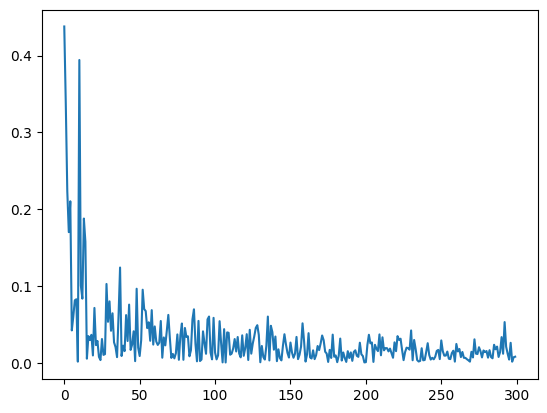

In [27]:
l = []
for i in range(300):
    val = np.corrcoef(X_sevoflurane_reduced[:,i],y_sevoflurane_num)[0,1]
    l.append(val)
l = np.abs(np.array(l))
plt.plot(l)
plt.show()
li_idx = np.argsort(l)

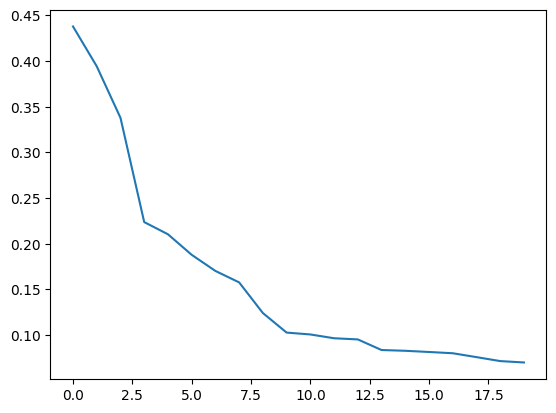

In [30]:
plt.plot(np.flip(np.sort(l))[:20])

In [28]:
li_idx

array([107, 199, 105, 130, 181, 200, 187, 175, 205, 297,   9, 269, 259,
       160, 235,  88, 141,  47,  90, 236, 191, 184, 136, 144, 238, 268,
       231, 225,  24, 234, 122, 239,  79,  76, 243, 295, 133,  91, 101,
        98, 245, 267, 155, 166, 256, 249, 255,  15, 164,  73, 284, 143,
       186, 189, 177,  71, 266, 265, 244, 218, 152,  65, 281, 149, 271,
       277, 163, 117, 298,  35, 263, 283, 132, 288,  23, 195, 179, 299,
       246,  83, 198,  50,  38, 194, 119, 182, 252, 253,  19, 180, 102,
       210, 167, 242,  26, 156, 110, 161, 197,  27, 274,  72,  94, 291,
       153, 273, 124, 111, 294, 116, 174,  74, 257, 217, 148, 100,  97,
       151, 185, 190, 279, 289, 226, 264, 240, 192, 270, 173, 254, 114,
       261, 215, 276, 251, 188, 220,  40, 208, 280, 247, 258, 278, 212,
       165, 193, 282,  84, 169, 248,  44, 176, 224, 229, 139, 142, 286,
       233, 262, 207, 216, 112, 237, 228, 214, 120, 213,  49, 227, 275,
        34, 293, 157, 287, 168, 131, 134, 145,  39,  67,  21, 20

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

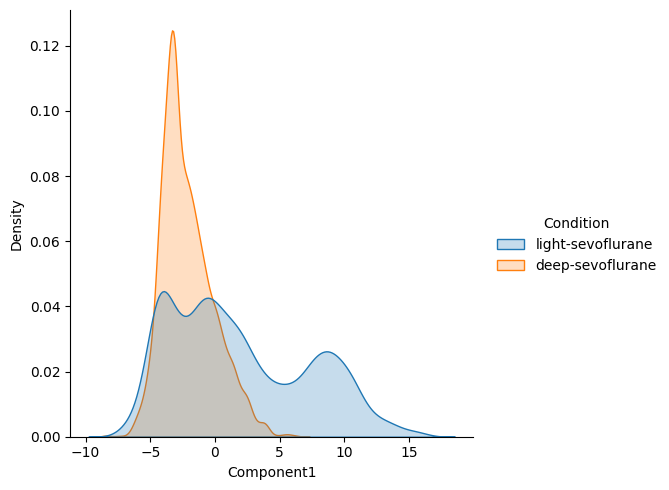

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


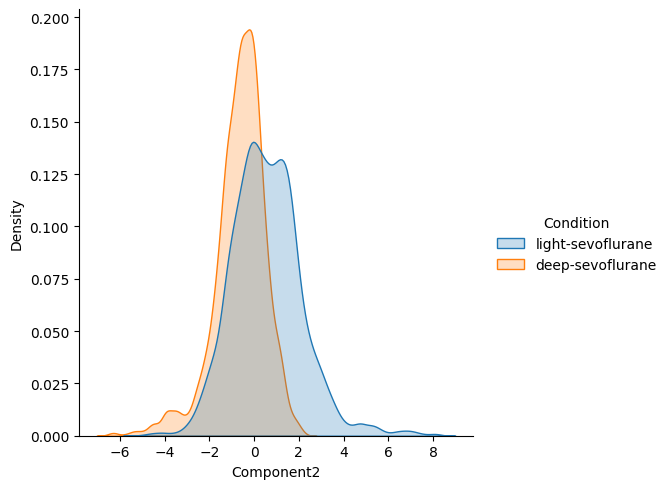

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


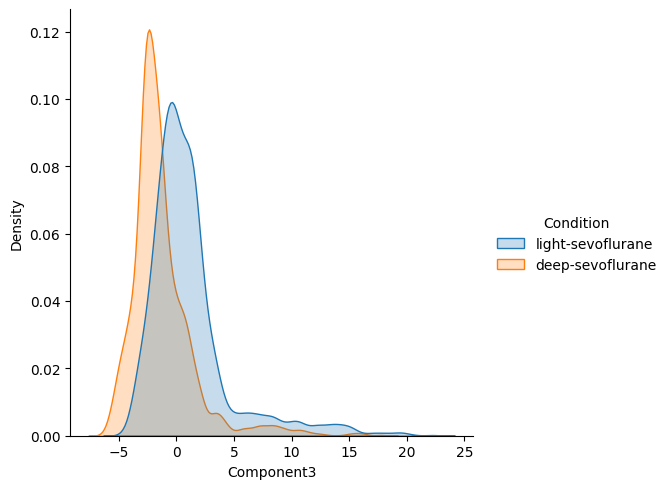

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


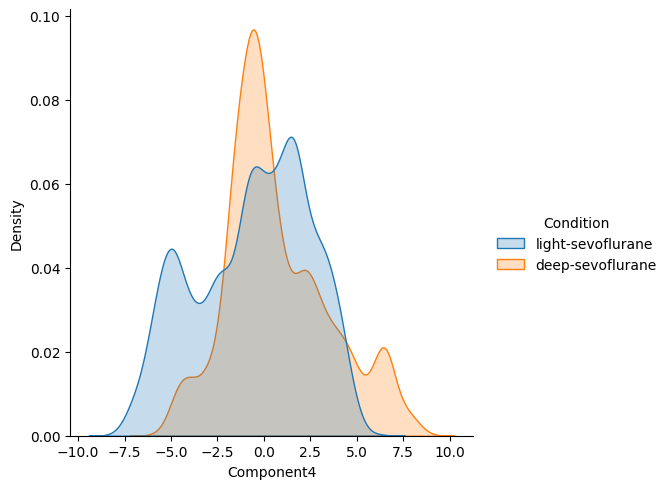

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


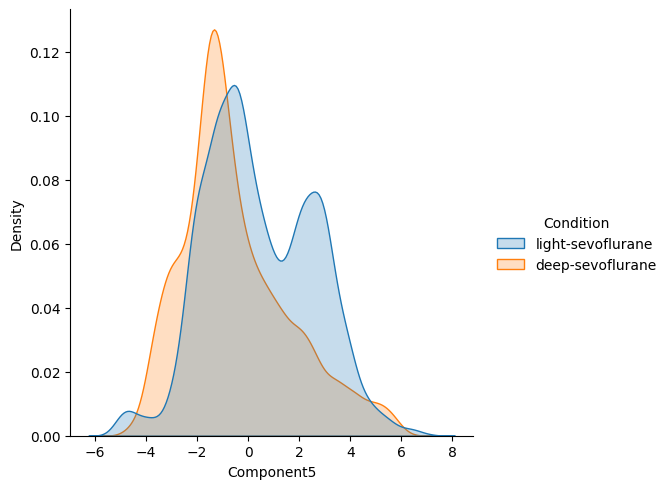

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


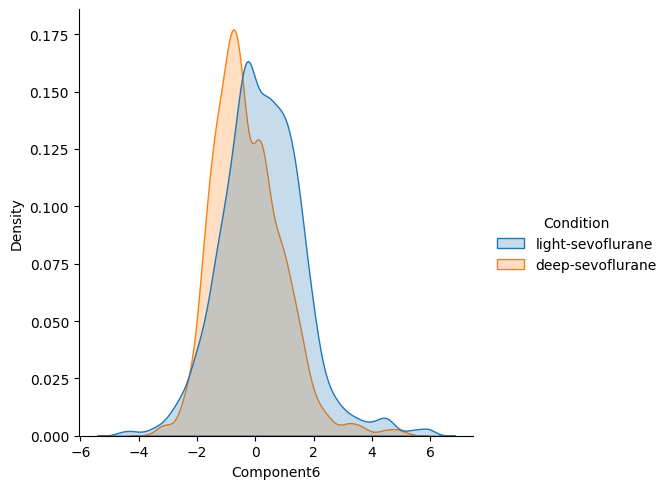

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


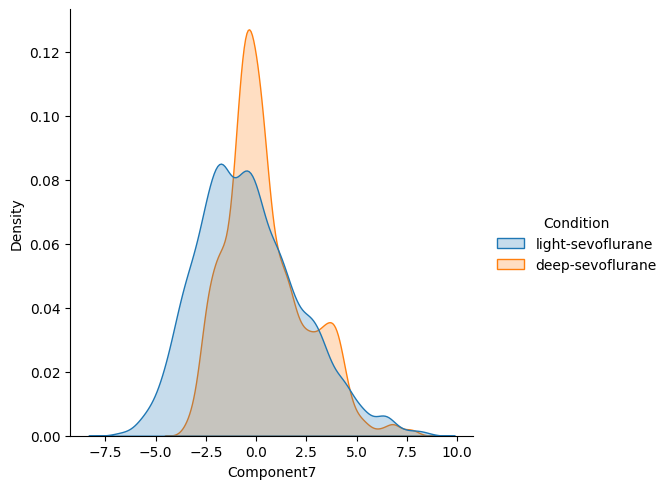

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


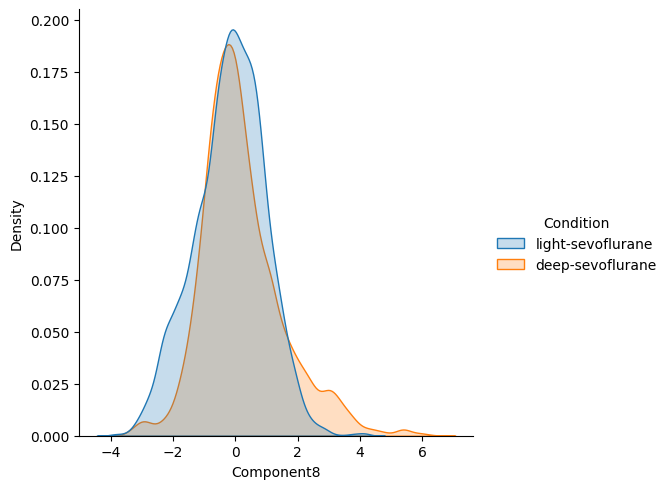

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


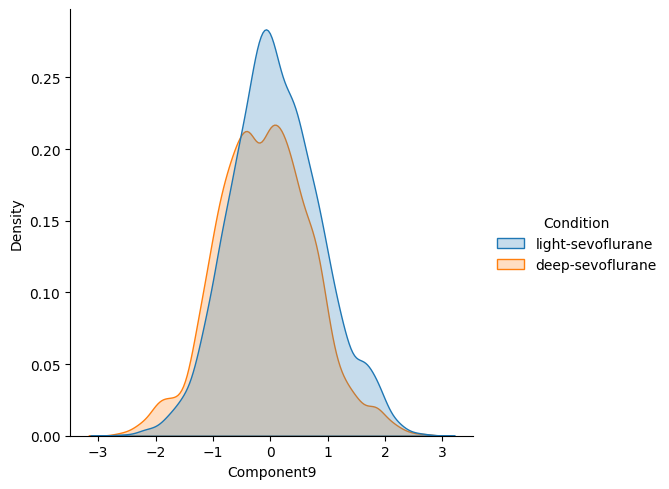

In [20]:
fig = plt.figure(figsize=(15,10))

for i in range(1,10):

    df_val = pd.DataFrame.from_dict({"val" : X_sevoflurane_reduced[:,li_idx[-i]].flatten()})
    df_cond = pd.DataFrame.from_dict({"condition" : y_sevoflurane})

    db_train = pd.concat([df_val,df_cond],axis = 1)
    db_train.columns = ["Component{}".format(i),"Condition"]

    sns.displot(data = db_train, x = "Component{}".format(i), hue = "Condition", kind="kde",  fill=True, color="g")
    
    #plt.legend()

    plt.show()

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

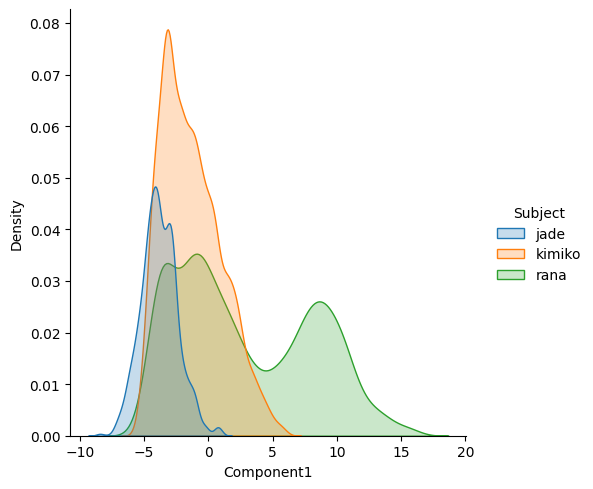

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


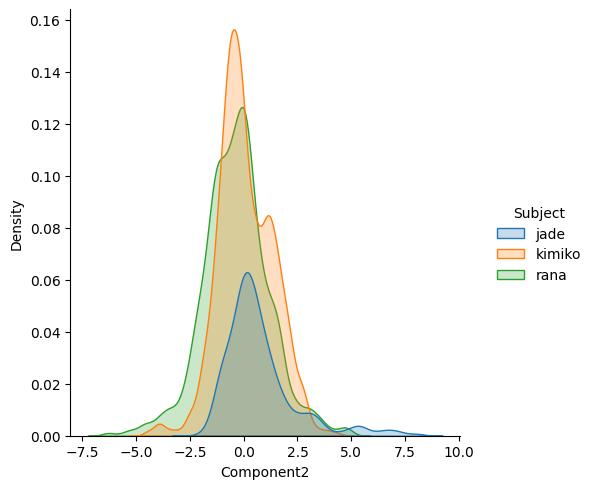

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


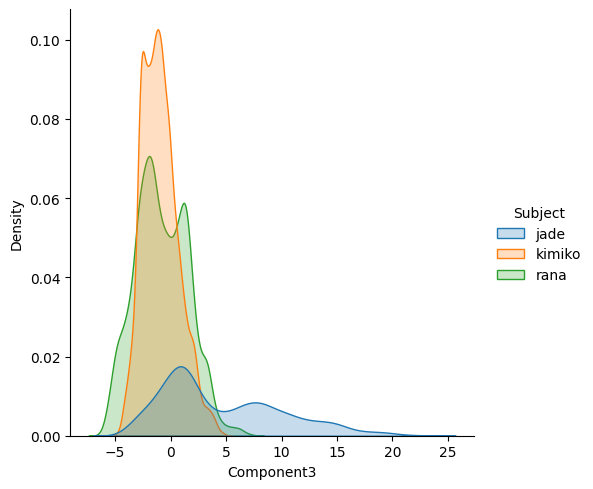

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


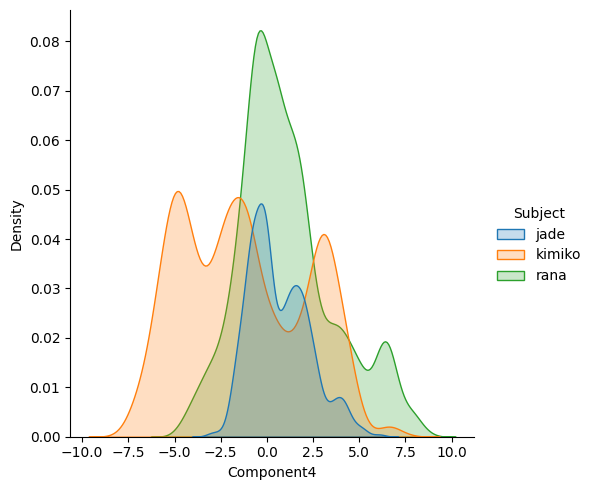

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


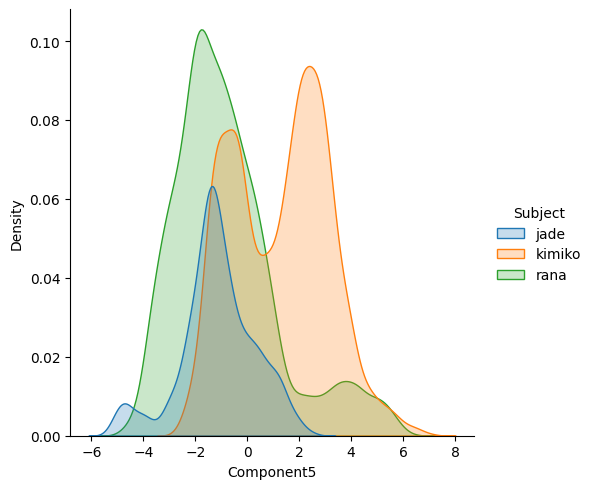

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


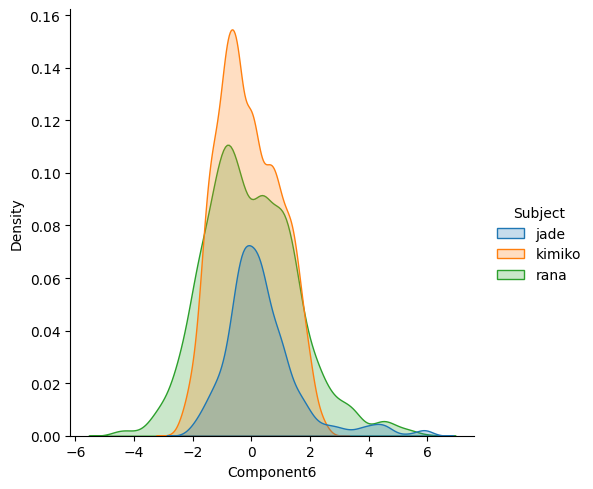

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


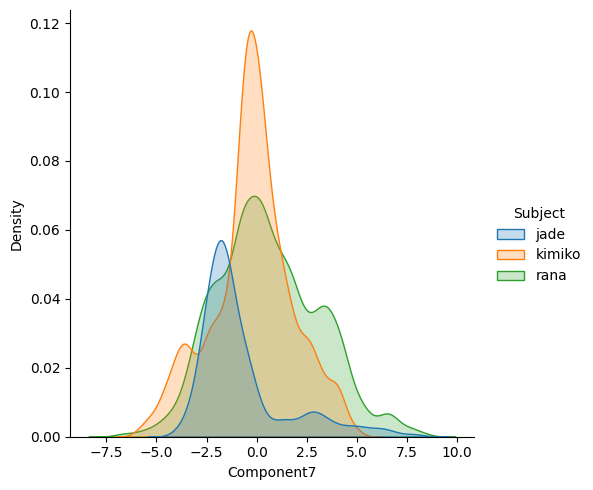

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


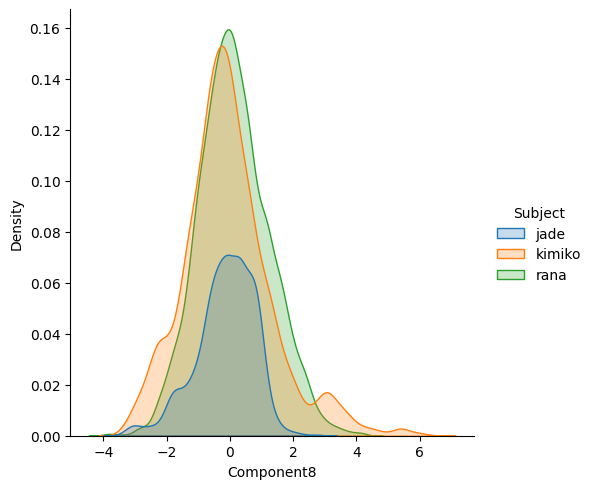

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


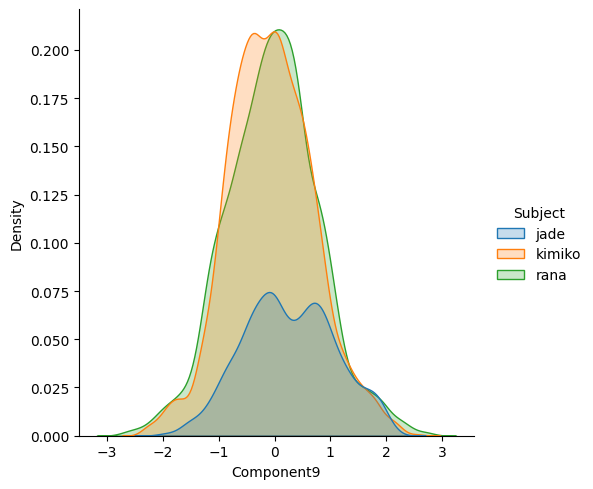

In [21]:
fig = plt.figure(figsize=(15,10))

for i in range(1,10):

    df_val = pd.DataFrame.from_dict({"val" : X_all_subjects_reduced[:,li_idx[-i]].flatten()})
    df_cond = pd.DataFrame.from_dict({"condition" : y_all_subjects})

    db_train = pd.concat([df_val,df_cond],axis = 1)
    db_train.columns = ["Component{}".format(i),"Subject"]

    sns.displot(data = db_train, x = "Component{}".format(i), hue = "Subject", kind="kde",  fill=True, color="g")
    
    #plt.legend()

    plt.show()

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

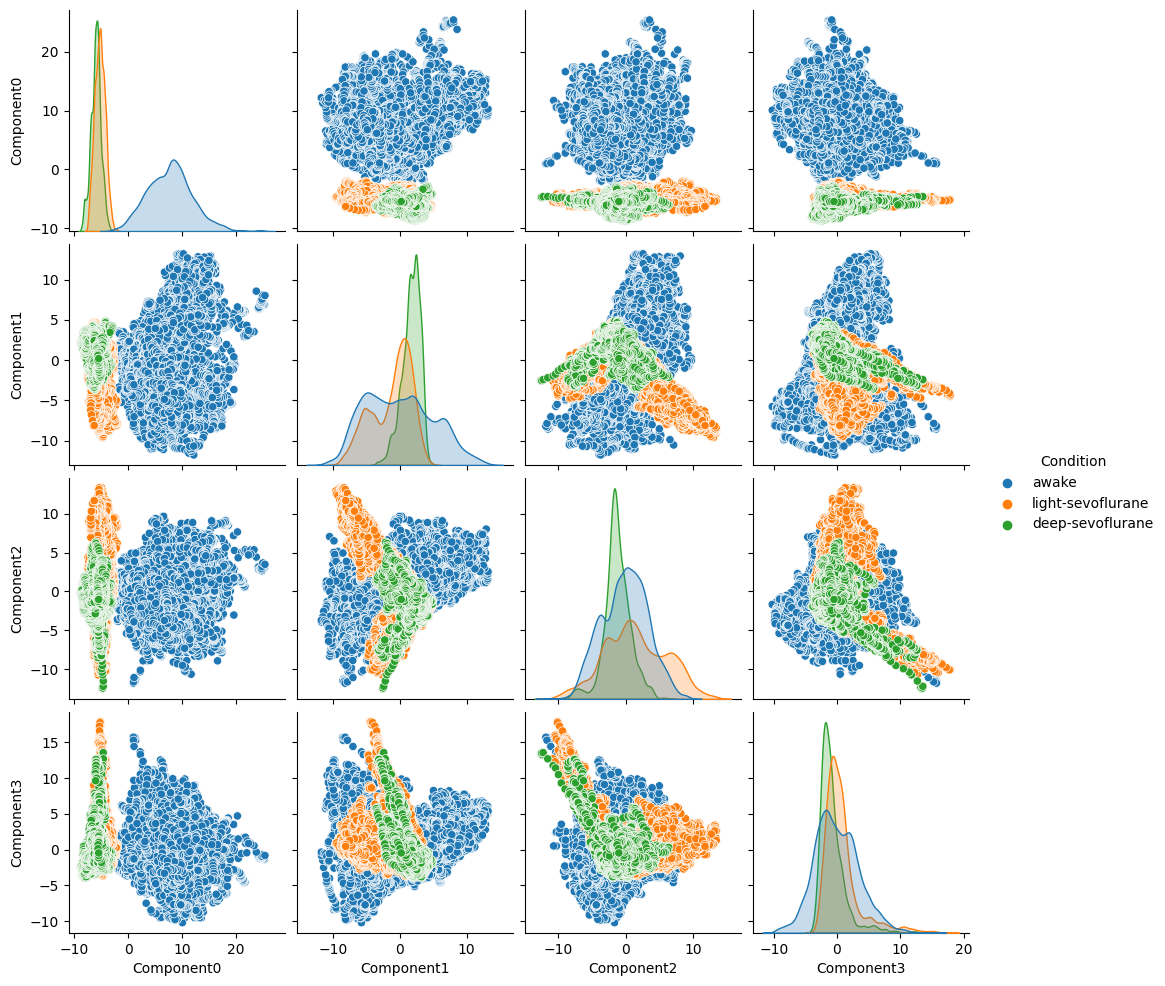

In [10]:
a = len(id_sessions_awake)
b = len(id_sessions_light_sevoflurane)
c = len(id_sessions_deep_sevoflurane)

dico = {}
columns = []
for i in range(4):
    dico["Component{}".format(i+1)] = X_sevoflurane_reduced[:,i].flatten()
    columns.append("Component{}".format(i))
dico["Condition"]= y
columns.append("Condition")
db = pd.DataFrame.from_dict(dico)
db.columns = columns

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

sns.pairplot(db,hue = "Condition")

plt.show()

In [43]:
print(meta["condition"][meta["monkey"] == "almira"].unique())
print(meta["condition"][meta["monkey"] == "jade"].unique())
print(meta["condition"][meta["monkey"] == "khali"].unique())
print(meta["condition"][meta["monkey"] == "kimiko"].unique())
print(meta["condition"][meta["monkey"] == "rana"].unique())

['awake']
['awake' 'light-propofol' 'deep-propofol' 'sevoflurane2' 'sevoflurane4']
['awake' 'ketamine' 'light-propofol' 'deep-propofol']
['ketamine' 'sevoflurane2' 'sevoflurane4']
['ketamine' 'light-propofol' 'deep-propofol' 'sevoflurane2' 'sevoflurane4']


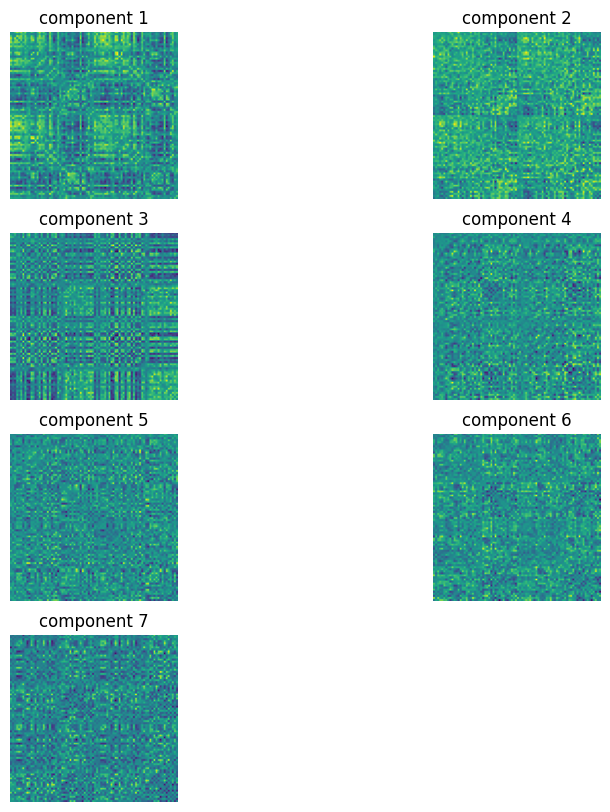

In [32]:
fig = plt.figure(figsize=(10,10))

for i in range(1,8):
    im = np.zeros((82,82))
    iu = np.triu_indices(82,k=1)
    il = np.tril_indices(82,k=-1)
    im[iu[0],iu[1]] = v[:,li_idx[-i]]
    im = np.transpose(im)
    im[iu[0],iu[1]] = v[:,li_idx[-i]]
    fig.add_subplot(4,2,i)
    plt.imshow(im)
    plt.axis("off")
    plt.title(label="component {}".format(i))
plt.show()

## Correlation with confound variables

In [9]:
confounds = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/Confounds/confounds.npy")

In [10]:
confounds_awake_sevoflurane = np.array([np.mean(confounds[i,j:j+35,:],axis = 0) for i in id_sessions_awake_sevoflurane for j in range(4,500-35)])

In [14]:
timeseries = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/timeseries.npy")
global_signal = np.mean(timeseries,axis = 2)
averaged_global_signal = np.array([np.mean(global_signal[i,j:j+35]) for i in id_sessions_awake_sevoflurane for j in range(496-35)])

In [17]:
x = X_sevoflurane_reduced[:,0]

In [19]:
for i in range(7):
    r = np.corrcoef(x,confounds_awake_sevoflurane[:,i])[0,1] 
    t = r * np.sqrt((n-2)/(1-r**2))
    print(r)
r = np.corrcoef(x,averaged_global_signal)
print(r[0,1])

-0.0017342624263985732
-0.08310692657468738
0.00870215191090847
-0.04757226805613667
0.006084353089494645
0.02721709446698729
0.17649577685245307
-0.03867576765186679


## Train-Test

In [5]:
id_sessions_awake_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana"]]
id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","rana","jade"]]
id_sessions_light_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","jade","rana"]]
id_sessions_deep_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["almira","khali","kimiko","jade","rana"]]
id_sessions_light_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["almira","khali","rana","jade","rana"]]
id_sessions_deep_sevoflurane_train = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["almira","khali","rana","jade","rana"]]

id_sessions_awake_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake" and meta["monkey"].iloc[i] in ["jade"]]
id_sessions_light_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_deep_propofol_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_light_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2" and meta["monkey"].iloc[i] in ["kimiko"]]
id_sessions_deep_sevoflurane_test = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4" and meta["monkey"].iloc[i] in ["kimiko"]]

In [22]:
id_sessions_anesthesia_train = np.concatenate([id_sessions_light_sevoflurane_train,id_sessions_deep_sevoflurane_train]).astype(int)
id_sessions_awake_anesthesia_train = np.concatenate([id_sessions_awake_train,id_sessions_light_sevoflurane_train,id_sessions_deep_sevoflurane_train]).astype(int)
id_sessions_anesthesia_test = np.concatenate([id_sessions_light_sevoflurane_test,id_sessions_deep_sevoflurane_test]).astype(int)
id_sessions_awake_anesthesia_test = np.concatenate([id_sessions_awake_test,id_sessions_light_sevoflurane_test,id_sessions_deep_sevoflurane_test]).astype(int)
id_sessions_awake_propofol = np.concatenate([id_sessions_awake,id_sessions_light_propofol,id_sessions_deep_propofol]).astype(int)
X_propofol = dfc_flat[id_sessions_awake_propofol,:,:].reshape(-1,3321)
y_propofol = np.array(["awake"]*461*len(id_sessions_awake) + ["light-propofol"]*461*len(id_sessions_light_propofol) + ["deep-propofol"]*461*len(id_sessions_deep_propofol))
id_sessions_subjects = np.concatenate([id_sessions_almira,id_sessions_jade,id_sessions_khali,id_sessions_kimiko,id_sessions_rana]).astype(int)
X_train = dfc_flat[id_sessions_awake_anesthesia_train,:,:].reshape(-1,3321)
y_train = np.array(["awake"]*461*len(id_sessions_awake_train) + ["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_train) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_train))
X = dfc_flat[id_sessions_awake_anesthesia_train,:,:].reshape(-1,3321)
X_test = dfc_flat[id_sessions_awake_anesthesia_test,:,:].reshape(-1,3321)
y = np.array(["awake"]*461*len(id_sessions_awake_train) + ["light-sevoflurane"]*461*len(id_sessions_light_sevoflurane_train) + ["deep-sevoflurane"]*461*len(id_sessions_deep_sevoflurane_train))
y_num = np.array([-1]*461*len(id_sessions_awake_test) + [0]*461*len(id_sessions_light_sevoflurane_test) + [1]*461*len(id_sessions_deep_sevoflurane_test))
X_all = dfc_flat[id_sessions_subjects,:,:].reshape(-1,3321)
y_all = np.array(["almira"]*461*len(id_sessions_almira) + ["jade"]*461*len(id_sessions_jade) + ["khali"]*461*len(id_sessions_khali) + ["kimiko"]*461*len(id_sessions_kimiko) + ["rana"]*461*len(id_sessions_rana))

In [8]:
pca = PCA(n_components=300)
pca.fit(X)
v = pca.components_.T
mean = np.mean(X,axis = 0)

In [9]:
X_reduced = (X - mean).dot(v)

In [29]:
X_train_reduced = (X_train - mean).dot(v)
X_propofol_reduced = (X_propofol - mean).dot(v)
X_test_reduced = (X_test - mean).dot(v)
X_all_reduced = (X_all - mean).dot(v)

In [20]:
y_num.shape

(16596,)

In [17]:
l = []
for i in range(300):
    val = np.corrcoef(X_reduced[:,i],y_num)
    l.append(val)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 17518 and the array at index 1 has size 16596

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

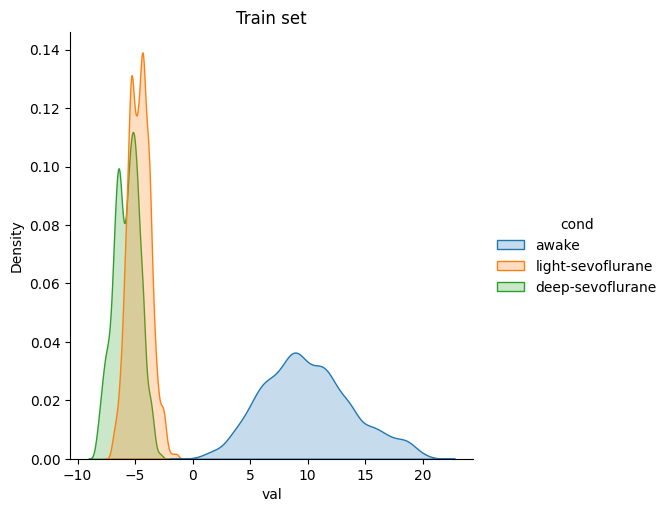

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

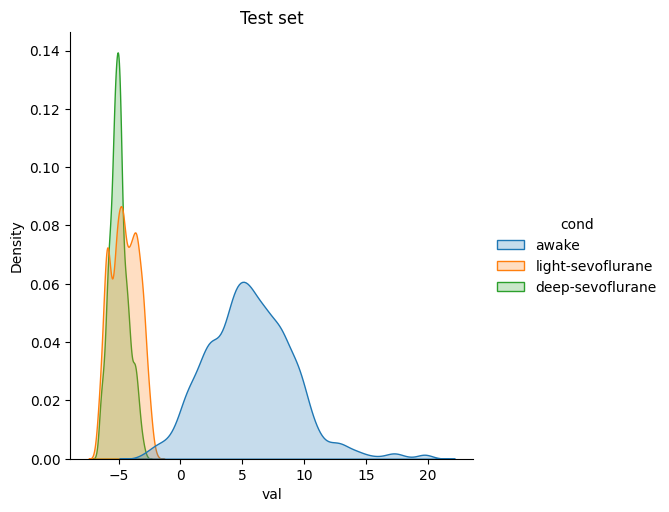

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

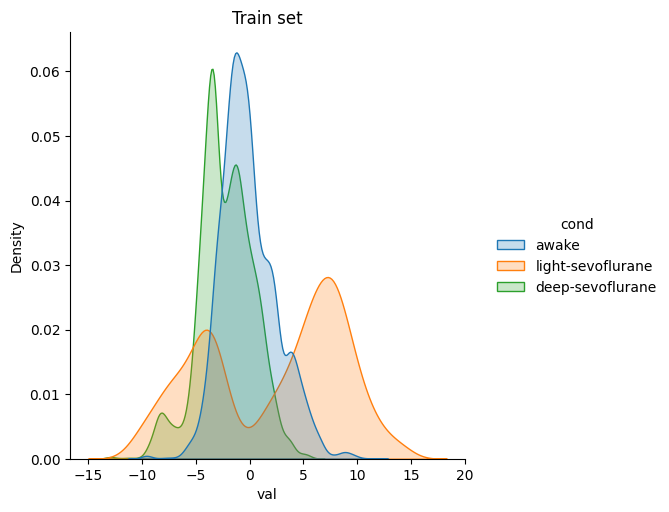

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

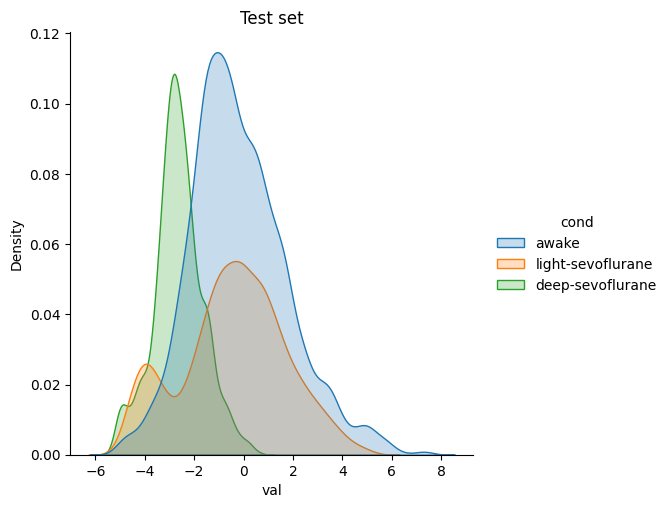

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

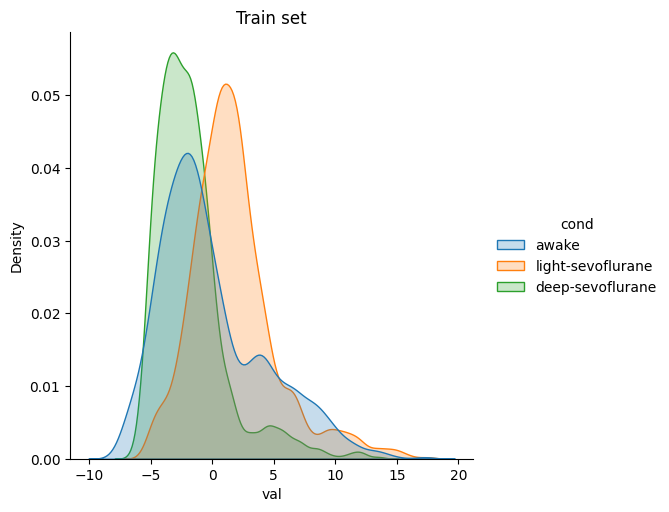

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

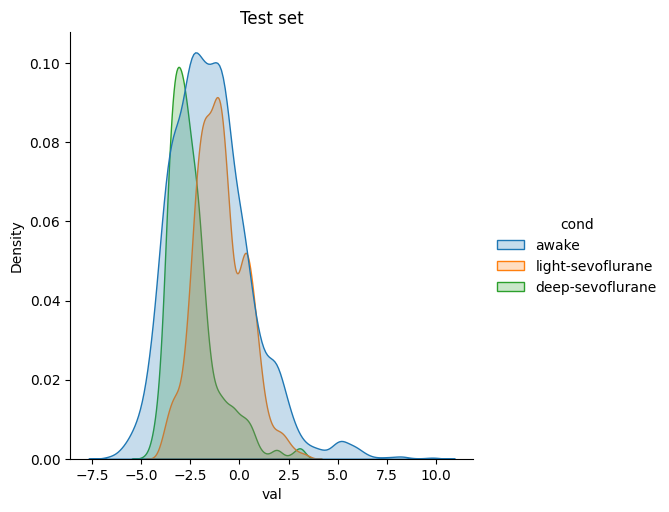

In [25]:
a = len(id_sessions_awake_train)
b = len(id_sessions_light_sevoflurane_train)
c = len(id_sessions_deep_sevoflurane_train)

for i in range(3):
    df_val = pd.DataFrame.from_dict({"val" : X_train_reduced[:,i].flatten()})
    df_cond = pd.DataFrame.from_dict({"condition" : y})

    db_train = pd.concat([df_val,df_cond],axis = 1)
    db_train.columns = ["val","cond"]

    compteur = 0
    bins = np.linspace(-10,10,100)

    fig = plt.figure(figsize=(15,10))

    sns.displot(data = db_train, x = "val", hue = "cond", kind="kde",  fill=True, color="g")

    plt.title("Train set")
    #plt.legend()

    plt.show()

    a = len(id_sessions_awake_test)
    b = len(id_sessions_light_sevoflurane_test)
    c = len(id_sessions_deep_sevoflurane_test)

    df_val = pd.DataFrame.from_dict({"val" : X_test_reduced[:,i].flatten()})
    df_cond = pd.DataFrame.from_dict({"condition" : y_test})

    db_test = pd.concat([df_val,df_cond],axis = 1)
    db_test.columns = ["val","cond"]

    compteur = 0
    bins = np.linspace(-10,10,100)

    fig = plt.figure(figsize=(15,10))

    sns.displot(data = db_test, x = "val", hue = "cond", kind="kde",  fill=True, color="g")

    plt.title("Test set")
    #plt.legend()

    plt.show()

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

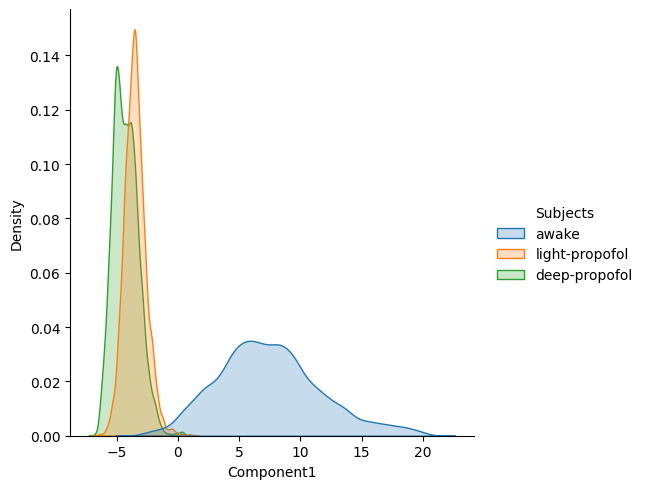

In [32]:
a = len(id_sessions_awake_train)
b = len(id_sessions_light_sevoflurane_train)
c = len(id_sessions_deep_sevoflurane_train)

df_val = pd.DataFrame.from_dict({"val" : X_propofol_reduced[:,0].flatten()})
df_cond = pd.DataFrame.from_dict({"condition" : y_propofol})

db_train = pd.concat([df_val,df_cond],axis = 1)
db_train.columns = ["Component1","Subjects"]

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(1):

    v_min = np.min(X_train_reduced[:,i])
    v_max = np.max(X_train_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)

    sns.displot(data = db_train, x = "Component1", hue = "Subjects", kind="kde",  fill=True, color="g")
    
    #plt.legend()

plt.show()

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

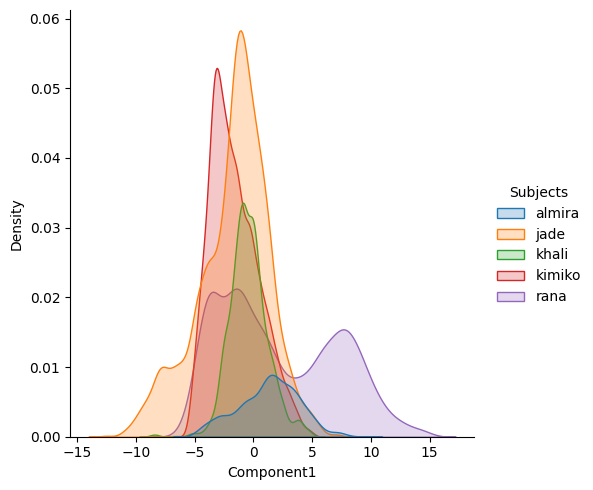

In [16]:
a = len(id_sessions_awake_train)
b = len(id_sessions_light_sevoflurane_train)
c = len(id_sessions_deep_sevoflurane_train)

df_val = pd.DataFrame.from_dict({"val" : X_all_reduced[:,0].flatten()})
df_cond = pd.DataFrame.from_dict({"condition" : y_all})

db_train = pd.concat([df_val,df_cond],axis = 1)
db_train.columns = ["Component1","Subjects"]

compteur = 0
bins = np.linspace(-10,10,100)

fig = plt.figure(figsize=(15,10))

for i in range(1):

    v_min = np.min(X_train_reduced[:,i])
    v_max = np.max(X_train_reduced[:,i])
    bins = np.linspace(v_min,v_max,100)

    sns.displot(data = db_train, x = "Component1", hue = "Subjects", kind="kde",  fill=True, color="g")
    
    #plt.legend()

plt.show()

Text(0.5, 1.0, 'component 0')

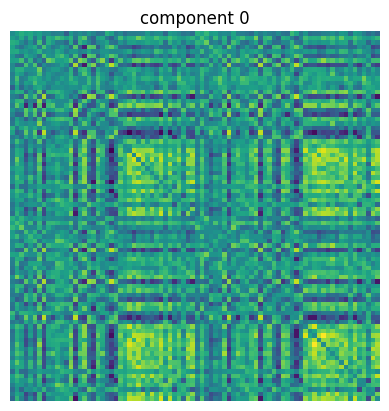

In [33]:
im = np.zeros((82,82))
iu = np.triu_indices(82,k=1)
il = np.tril_indices(82,k=-1)
im[iu[0],iu[1]] = v[:,0]
im = np.transpose(im)
im[iu[0],iu[1]] = v[:,0]
plt.imshow(im)
plt.axis("off")
plt.title(label="component {}".format(i))

In [191]:
y_test_num = np.array([0]*461*len(id_sessions_light_sevoflurane_test) + [1]*461*len(id_sessions_deep_sevoflurane_test))
val = np.linspace(np.min(X_test_reduced),np.max(X_test_reduced),300)
l_test = np.zeros((X_test_reduced.shape[1],2))
length = len(y_test_num)
fact0 = np.sum(y_test_num == 0)
fact1 = np.sum(y_test_num == 1)
for i in range(len(l_test)):
    accu = np.zeros((len(val)))
    accu2 = X_test_reduced[:,i].flatten()
    for k in range(len(val)):
        pred = (accu2 > val[k]).astype(int)
        accu[k] = np.sum((y_test_num == 0) * (pred == 0)) / (2*fact0) + np.sum((y_test_num == 1) * (pred == 1)) / (2*fact1)
    l_test[i] = [np.max(accu),np.argmax(accu)]

In [189]:
y_train_num = np.array([0]*461*len(id_sessions_light_sevoflurane_train) + [1]*461*len(id_sessions_deep_sevoflurane_train))
val = np.linspace(np.min(X_train_reduced),np.max(X_train_reduced),300)
l_train = np.zeros((X_train_reduced.shape[1],2))
length = len(y_train_num)
fact0 = np.sum(y_train_num == 0)
fact1 = np.sum(y_train_num == 1)
for i in range(len(l_train)):
    accu = np.zeros((len(val)))
    accu2 = X_train_reduced[:,i].flatten()
    for k in range(len(val)):
        pred = (accu2 > val[k]).astype(int)
        accu[k] = np.sum((y_train_num == 0) * (pred == 0)) / (2*fact0) + np.sum((y_train_num == 1) * (pred == 1)) / (2*fact1)
    l_train[i] = [np.max(accu),np.argmax(accu)]

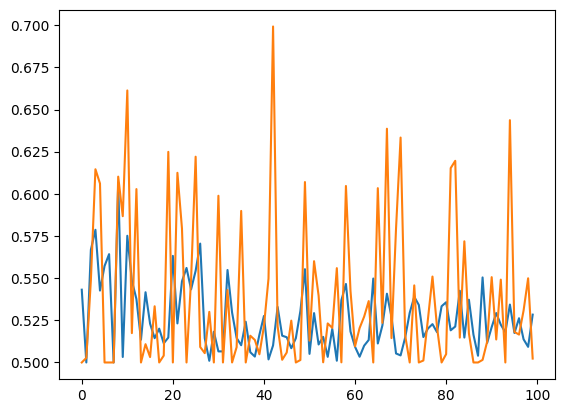

In [192]:
plt.plot(l_train[:,0])
plt.plot(l_test[:,0])

# PCA on single subject

In [27]:
id_sessions_almira = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "almira" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_jade = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_khali = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "khali" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_kimiko = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "kimiko" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]
id_sessions_rana = [i for i in range(len(meta)) if meta["monkey"].iloc[i] == "rana" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]]

### Almira

In [28]:
X_jade = dfc_flat[id_sessions_jade,:,:].reshape(-1,3321)
y_jade = np.concatenate([np.array([meta["condition"].iloc[i]]*461) for i in range(len(meta)) if meta["monkey"].iloc[i] == "jade" and meta["condition"].iloc[i] in ["sevoflurane2","sevoflurane4"]])

In [29]:
pca = PCA(n_components=100)
pca.fit(X_jade)
v = pca.components_.T
mean = np.mean(X_jade,axis = 0)
X_jade_reduced = (X_jade - mean).dot(v)

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

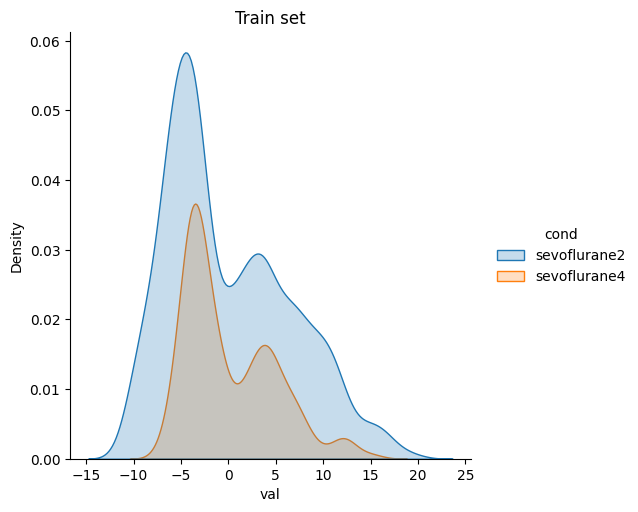

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

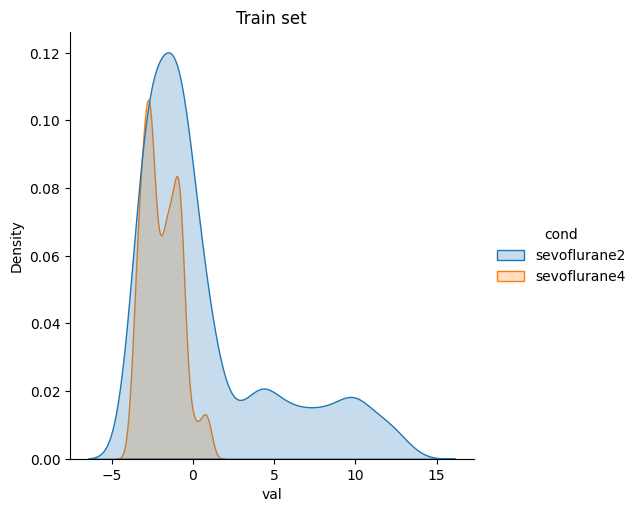

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

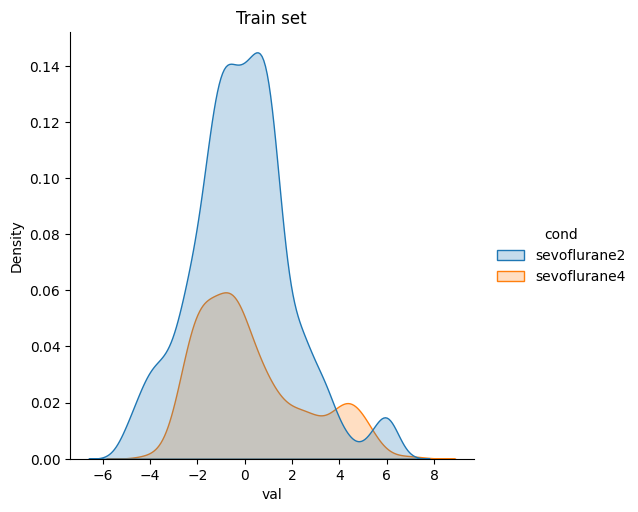

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

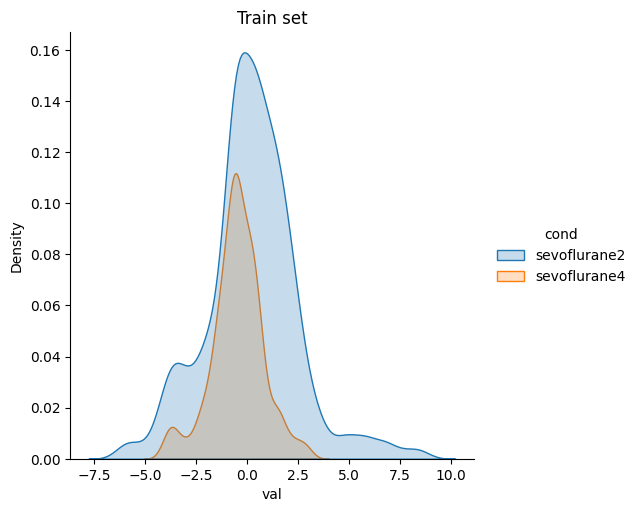

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

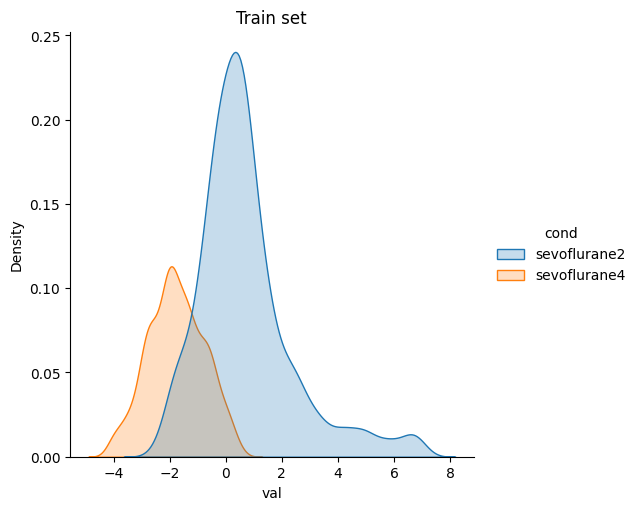

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

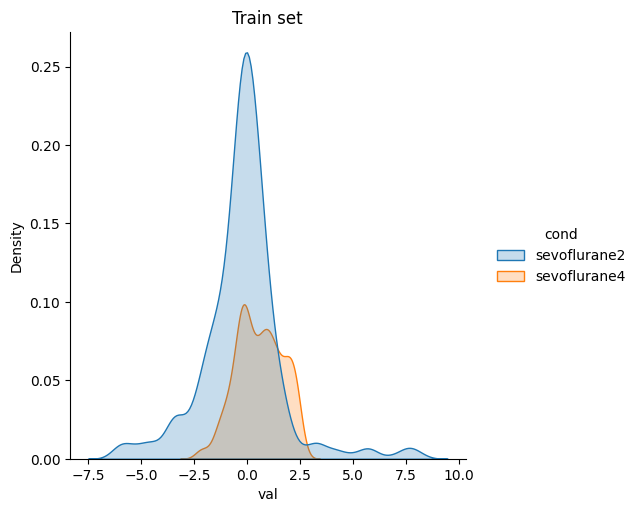

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

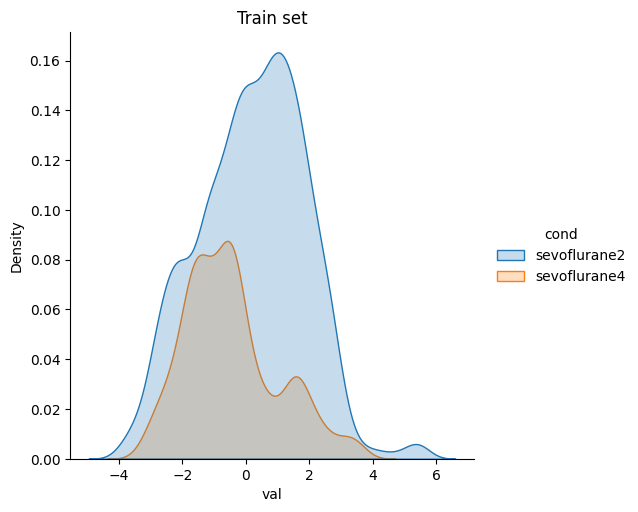

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

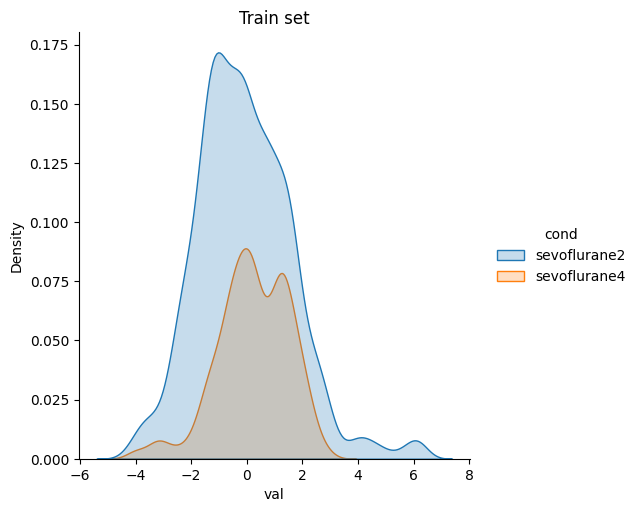

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

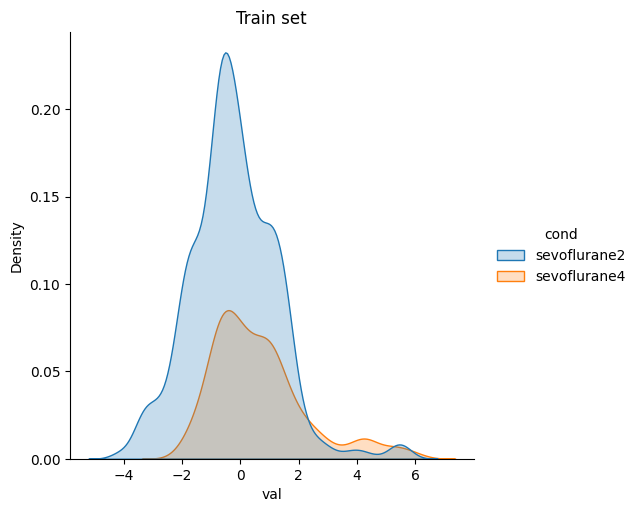

/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x1000 with 0 Axes>

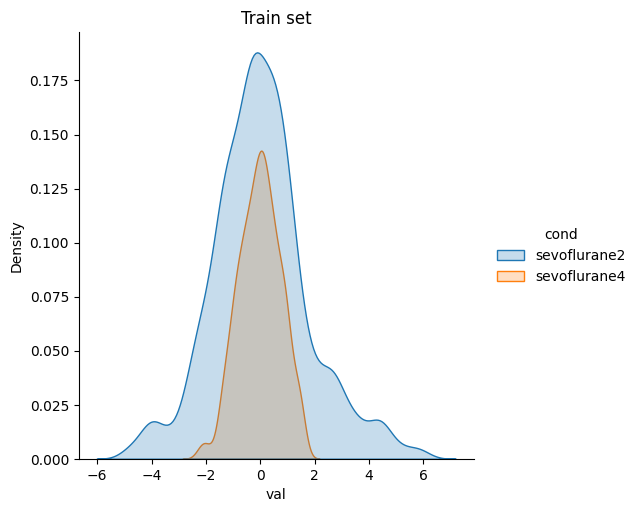

In [30]:
for i in range(10):
    df_val = pd.DataFrame.from_dict({"val" : X_jade_reduced[:,i].flatten()})
    df_cond = pd.DataFrame.from_dict({"condition" : y_jade})

    db_train = pd.concat([df_val,df_cond],axis = 1)
    db_train.columns = ["val","cond"]

    compteur = 0
    bins = np.linspace(-10,10,100)

    fig = plt.figure(figsize=(15,10))

    sns.displot(data = db_train, x = "val", hue = "cond", kind="kde",  fill=True, color="g")

    plt.title("Train set")
    #plt.legend()

    plt.show()

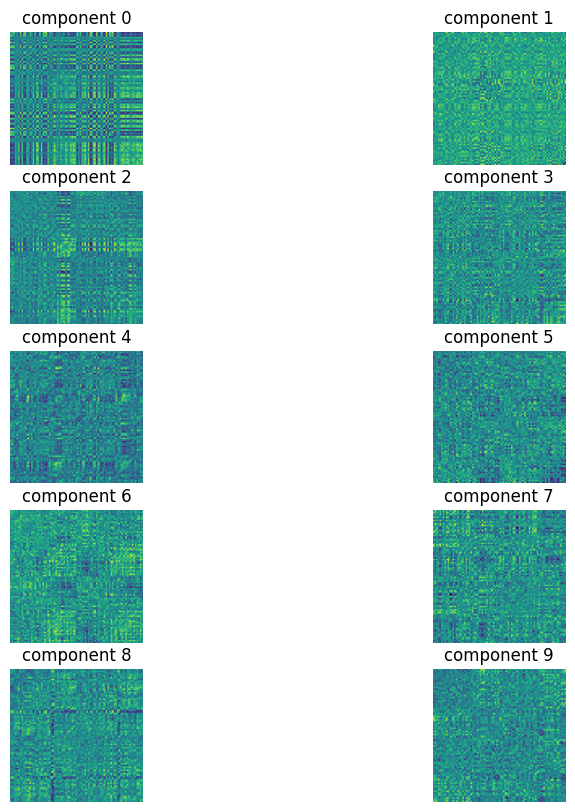

In [31]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    im = np.zeros((82,82))
    iu = np.triu_indices(82,k=1)
    il = np.tril_indices(82,k=-1)
    im[iu[0],iu[1]] = v[:,i]
    im = np.transpose(im)
    im[iu[0],iu[1]] = v[:,i]
    fig.add_subplot(5,2,i+1)
    plt.imshow(im)
    plt.axis("off")
    plt.title(label="component {}".format(i))
plt.show()

In [33]:
np.sum(y_jade == "sevoflurane4")//461

2

In [26]:
y_jade

array(['sevoflurane2', 'sevoflurane2', 'sevoflurane2', ...,
       'sevoflurane4', 'sevoflurane4', 'sevoflurane4'], dtype='<U12')

In [34]:
X_jade_sessions = dfc_flat[id_sessions_jade,:,:]
li_var = []
for i in range(X_jade_sessions.shape[0]):
    li_var.append(np.var(X_jade_sessions[i,:,:]))

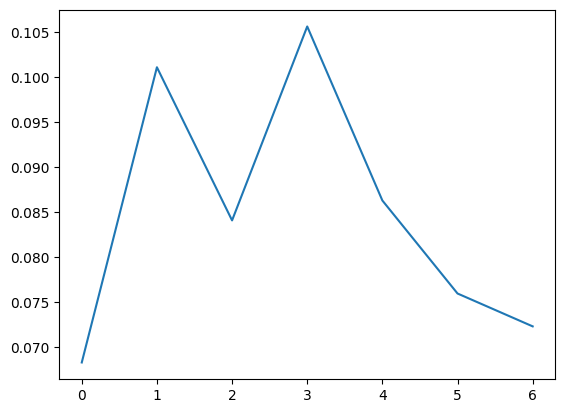

In [35]:
plt.plot(li_var)